In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.optimize import curve_fit


In [2]:
# First read in the unvalidated GALAH DR4 file
galah = Table.read('../spectrum_post_processing//galah_dr4_allspec_not_validated.fits')
galah = galah[galah['flag_sp'] < 64]

In [3]:
gbs = Table.read('data/GALAH_GBS2.1.fits')

In [4]:
gbs[-1]['sobject_id'] = 210115002201239

In [5]:
gbs_galah_match = []
galah_gbs_match = []

for each_sobject_id in range(len(galah['sobject_id'])):
    if galah['sobject_id'][each_sobject_id] not in [140709001901194,150204002101256]:
        try:
            side_a = np.where(
                    galah['sobject_id'][each_sobject_id] == gbs['sobject_id']
                )[0][0]
            side_b = each_sobject_id
            gbs_galah_match.append(side_a)
            galah_gbs_match.append(side_b)
        except:
            pass
gbs_galah_match = np.array(gbs_galah_match)
galah_gbs_match = np.array(galah_gbs_match)


In [6]:
gbs[gbs_galah_match][:10]

sobject_id,P2,P3,P4,P5,StarID1,StarID2,StarID3,StarID4,RAJ2000,DEJ2000,SpType,Teff,e_Teff,logg,e_logg,__Fe_H_,e__Fe_H_,logeps_Mg_,e_logeps_Mg_,logeps_Si_,e_logeps_Si_,logeps_Ca_,e_logeps_Ca_,logeps_Ti_,e_logeps_Ti_,logeps_Sc_,e_logeps_Sc_,logeps_V_,e_logeps_V_,logeps_Cr_,e_logeps_Cr_,logeps_Mn_,e_logeps_Mn_,logeps_Co_,e_logeps_Co_,logeps_Ni_,e_logeps_Ni_,__Mg_H_,e__Mg_H_,__Si_H_,e__Si_H_,__Ca_H_,e__Ca_H_,__Ti_H_,e__Ti_H_,__Sc_H_,e__Sc_H_,__V_H_,e__V_H_,__Cr_H_,e__Cr_H_,__Mn_H_,e__Mn_H_,__Co_H_,e__Co_H_,__Ni_H_,e__Ni_H_,SimbadName,GroupID,GroupSize
,,,,,,,,,deg,deg,,K,K,[cm/s2],[cm/s2],[Sun],[Sun],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],[Sun],,,
int64,bytes2,bytes2,bytes2,bytes2,bytes9,bytes8,bytes9,int64,float64,float64,bytes15,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes9,int32,int32
131216002601003,P2,P3,P4,P5,mu Leo,HD85503,HIP48455,643819484616249984,148.19090416666666,26.006952777777773,K2III,4474,60,2.51,0.11,0.25,0.15,8.12,0.11,8.01,0.09,6.6,0.12,5.22,0.1,3.45,0.06,4.23,0.08,5.91,0.08,5.39,0.2,5.34,0.09,6.5,0.12,0.466,0.132,0.522,0.132,0.28,0.139,0.322,0.157,0.23,0.106,0.296,0.13,0.335,0.134,0.087,0.287,0.452,0.162,0.324,0.154,mu Leo,1,2
131216003201003,P2,P3,P4,P5,HD 84937,HD84937,HIP48152,615943806835727872,147.23374166666665,13.744255555555554,sdF5,6356,97,4.06,0.04,-2.03,0.08,5.89,0.11,5.76,0.18,4.66,0.08,3.24,0.11,1.33,0.15,--,--,3.35,0.07,--,--,--,--,4.12,0.12,-1.764,0.12,-1.731,0.177,-1.665,0.093,-1.664,0.119,-1.895,0.157,--,--,-2.228,0.101,--,--,--,--,-2.062,0.146,HD 84937,2,2
131220004401099,P2,P3,P4,P5,ksi Hya,HD100407,HIP56343,3478394889482871808,173.25047916666665,-31.85762222222222,G7III,5044,40,2.87,0.02,0.16,0.2,7.68,0.11,7.57,0.06,6.39,0.07,4.93,0.08,3.28,0.11,3.98,0.07,5.66,0.04,5.2,0.1,4.88,0.08,6.22,0.08,0.034,0.118,0.077,0.079,0.068,0.101,0.028,0.1,0.062,0.137,0.053,0.094,0.077,0.062,-0.105,0.18,-0.009,0.094,0.035,0.118,ksi Hya,3,2
140708003401078,P2,P3,P4,P5,mu Ara,HD160691,HIP86796,5945941905576552448,266.03625416666665,-51.83405277777777,G3IV-V,--,--,4.3,0.03,0.35,0.13,8.01,0.04,7.82,0.04,6.64,0.05,5.29,0.05,3.62,0.06,4.36,0.03,5.95,0.04,5.73,0.04,5.31,0.03,6.6,0.05,0.36,0.063,0.327,0.045,0.32,0.069,0.388,0.08,0.401,0.076,0.427,0.067,0.37,0.058,0.43,0.087,0.424,0.06,0.416,0.069,mu Ara,--,--
140708005801203,P2,P3,P4,P5,bet Hyi,HD2151,HIP2021,4683897617108298752,6.437791666666666,-77.25424722222222,G0V,5873,45,3.98,0.02,-0.04,0.06,7.61,0.04,7.42,0.03,6.26,0.06,4.83,0.04,3.18,0.04,3.85,0.04,5.48,0.05,5.18,0.03,4.81,0.03,6.09,0.03,-0.038,0.05,-0.067,0.037,-0.061,0.064,-0.074,0.055,-0.043,0.047,-0.079,0.059,-0.098,0.063,-0.121,0.062,-0.077,0.045,-0.085,0.045,bet Hyi,--,--
140708006401203,P2,P3,P4,P5,tau Cet,HD10700,HIP8102,2452378776434276864,26.017012499999996,-15.937480555555554,G8.5V,5414,21,--,--,-0.49,0.03,7.43,0.03,7.14,0.03,6.03,0.05,4.74,0.07,2.88,0.06,3.68,0.03,5.16,0.04,4.79,0.04,4.54,0.03,5.73,0.04,-0.224,0.054,-0.354,0.04,-0.291,0.086,-0.165,0.099,-0.343,0.075,-0.248,0.099,-0.417,0.065,-0.511,0.071,-0.35,0.075,-0.447,0.078,tau Cet,--,--
140709004401117,P2,P3,P4,P5,gam Sge,HD189319,HIP98337,1823067317695767552,299.6892875,19.49214722222222,M0III,3807,49,1.05,0.32,-0.17,0.39,7.69,0.1,7.64,0.1,6.03,0.09,4.63,0.1,2.9,0.29,3.62,0.16,5.43,0.06,--,--,4.79,0.09,6.01,0.13,0.042,0.109,0.15,0.241,-0.292,0.183,-0.266,0.202,-0.319,0.348,-0.314,0.223,-0.152,0.144,--,--,-0.101,0.211,-0.174,0.274,gam Sge,--,--
140710000801284,P2,P3,P4,P5,HD 107328,HD107328,HIP60172,3701693091058501632,185.0874208333333,3.312572222222222,K0IIIb,4496,59,2

In [7]:
galah[galah_gbs_match][:10]

sobject_id,tmass_id,gaiadr3_source_id,flag_sp,chi2_sp,model_name,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,snr [4]
int64,bytes16,int64,int64,float32,bytes16,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
131216002601003,09524585+2600248,643819484617141504,4,11.417083,4500_2.00_0.00,4499.0757,0.5604881,2.4453762,0.001982448,0.22083943,0.0007825262,0,1.564405,0.0007373396,3.462567,0.005493523,-1.5581433,0.003735065,0,-0.10012323,0.0020177977,0,0.37067422,0.0015928206,0,-0.24291372,0.0030620669,0,0.4653613,0.0016654489,0,0.004115656,0.0010759811,0,-0.25592104,0.0036681944,0,0.1705636,0.0011558784,0,-0.99649745,0.0066377423,1,0.0309139,0.0013730661,0,-0.0014554728,0.001208049,0,0.06180691,0.0005855659,0,0.24121578,0.0008533639,0,0.029303363,0.0006438847,0,0.20792685,0.0011765367,0,0.37874418,0.00077142654,0,0.118806526,0.00057690573,0,0.56738037,0.0029542316,0,-0.069573894,0.0045932643,0,--,--,2,-0.14399041,0.0041872994,0,-0.20070565,0.0030238028,0,0.088320225,0.0017406724,0,0.27558795,0.0052653425,0,-0.51211184,0.005328177,0,-0.1133381,0.005317481,0,-0.14781646,0.0021930614,0,-0.5423752,0.0022116508,0,-0.33227813,0.0020582255,0,-0.6148413,0.0028132594,0,1.7109855,0.0068526343,0,--,-130.0,--,0.24189371,0.55283946,0.069721386,0.24448918,-2.5794218,0.022701867,0.10523918,15.532752,0.03284929,0.38672894,-30.481337,-0.02614712,0.13587137,19.12217,482.95697 .. 280.02988
131216003201003,09485609+1344395,615943806835727872,32,1.2647384,6250_4.00_-2.00,6263.469,1.7976012,3.4177287,0.022570902,-2.3937933,0.013577378,0,1.8404852,0.11784798,8.438513,0.13653238,3.3136628,0.031828903,0,0.74999857,0.027374798,1,--,--,2,0.5838513,0.090871505,1,--,--,2,--,--,2,--,--,2,--,--,2,0.43982613,0.11922074,1,0.75257146,0.01811303,0,--,--,2,0.5851963,0.023564756,0,--,--,2,--,--,2,0.0065037757,0.04844099,0,--,--,2,-0.09735269,0.09973856,1,--,--,2,--,--,2,--,--,2,--,--,2,0.044620812,0.056569032,1,--,--,2,--,--,2,--,--,2,0.21149327,0.0312572,0,--,--,2,--,--,2,--,--,2,--,--,2,--,--,2,--,-170.0,--,0.027120281,0.1420783,0.008194119,0.14315341,-85.61025,0.023298752,1.5434155,125.460846,-0.0016547086,0.013605867,-0.2531286,0.002572037,0.15833193,-35.01976,231.02

In [8]:
galah[galah_gbs_match][10:]

sobject_id,tmass_id,gaiadr3_source_id,flag_sp,chi2_sp,model_name,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,snr [4]
int64,bytes16,int64,int64,float32,bytes16,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
140710006601104,03021680+0405226,-1,44,67.88056,4000_1.00_-0.25,3669.4614,0.10258741,-0.21762598,0.0004459584,-0.9790067,0.00013336883,0,1.7451493,0.00017049389,5.452272,0.0010926187,-3.337636,0.0014861,0,0.24370489,0.0003300879,0,-0.8118888,0.0006064308,0,0.31939033,0.00022177928,0,0.2587937,0.0004642566,0,0.10528967,0.0002697641,0,1.248282,0.0004992821,0,0.3094131,0.00041080092,0,1.9910752,0.00086003816,0,-0.43807504,0.0005460963,0,0.13182943,0.00026451857,0,0.250217,0.00014269463,0,0.40686622,0.00021254225,0,-0.07552436,0.00021326722,0,0.0816478,0.00035767065,0,0.48891124,0.00024441245,0,-0.15202352,0.00023938456,0,-0.7776681,0.0007153194,0,-0.06584565,0.00075998175,0,--,--,2,1.0245105,0.00069150014,0,-0.022451125,0.0006918831,0,0.5355052,0.0002566728,0,-0.66292393,0.00069815863,0,-0.7564768,0.0006567422,0,0.9240842,0.00042788463,0,0.36051023,0.0004452642,0,-0.5062803,0.00043815342,0,-0.08291418,0.00027164153,0,-0.048695542,0.00037372476,0,2.4180946,0.0010946868,0,-65.0,-34.75,-25.56,0.51972276,0.9571714,0.026118001,0.16462159,-79.767685,0.00014052246,0.5157718,9.653471,-1.1186794e-06,0.47968438,-8.263586,-0.009588522,0.087387614,21.606647,1998.7673 .. 1480.7343
140710007601032,03325591-0927298,5164707970261890560,4,6.7411146,5000_4.50_0.00,5062.8804,0.29417342,4.585353,0.0004452818,-0.057685487,0.0002609485,0,0.86646444,0.0006917676,4.0395026,0.0024317994,-0.5226666,0.0019324495,0,-0.031309582,0.0010701079,0,-0.2172052,0.0015283979,0,-0.20261249,0.0025230516,0,-0.1441078,0.0006494245,0,0.103789344,0.00047623453,0,0.066587254,0.0020757138,0,0.057790514,0.00042094727,0,0.091465294,0.002551336,0,0.16156681,0.00042950848,0,-0.08439766,0.0005607295,0,0.04403287,0.00026349814,0,0.17763029,0.00044122103,0,0.010392195,0.00029053667,0,0.083911195,0.00028879766,0,-0.063522786,0.00057035306,0,-0.0802221,0.00024305437,0,-0.15133543,0.0010404913,0,-0.113545686,0.000994425,0,1.3444573,0.009355394,0,-0.013812967,0.0033893052,0,0.192411

In [9]:
comparison = dict()

comparison['GBS'] = gbs['StarID1'][gbs_galah_match]
comparison['sobject_id'] = gbs['sobject_id'][gbs_galah_match]
comparison['teff_gbs'] = np.array([float(gbs['Teff'][gbs_galah_match][x]) for x in range(len(gbs['Teff'][gbs_galah_match]))])
comparison['teff_gbs'][comparison['teff_gbs'] < 0] = np.NaN
comparison['logg_gbs'] = gbs['logg'][gbs_galah_match]
comparison['fe_h_gbs'] = gbs['__Fe_H_'][gbs_galah_match]

comparison['e_teff_gbs'] = np.array([float(gbs['e_Teff'][gbs_galah_match][x]) for x in range(len(gbs['e_Teff'][gbs_galah_match]))])
comparison['e_logg_gbs'] = gbs['e_logg'][gbs_galah_match]
comparison['e_fe_h_gbs'] = gbs['e__Fe_H_'][gbs_galah_match]

comparison['teff'] = galah['teff'][galah_gbs_match]
comparison['e_teff'] = galah['e_teff'][galah_gbs_match]
comparison['logg'] = galah['logg'][galah_gbs_match]
comparison['e_logg'] = galah['e_logg'][galah_gbs_match]
comparison['fe_h'] = galah['fe_h'][galah_gbs_match]
comparison['e_fe_h'] = galah['fe_h'][galah_gbs_match]

/var/folders/fk/njpttmdx5yb1y0hp7br9z1cc0000gn/T/ipykernel_8000/1170838571.py:5: UserWarning: Warning: converting a masked element to nan.
  comparison['teff_gbs'] = np.array([float(gbs['Teff'][gbs_galah_match][x]) for x in range(len(gbs['Teff'][gbs_galah_match]))])
/var/folders/fk/njpttmdx5yb1y0hp7br9z1cc0000gn/T/ipykernel_8000/1170838571.py:10: UserWarning: Warning: converting a masked element to nan.
  comparison['e_teff_gbs'] = np.array([float(gbs['e_Teff'][gbs_galah_match][x]) for x in range(len(gbs['e_Teff'][gbs_galah_match]))])


In [10]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [11]:
lbol_bias = {}

for each_param in ['teff','logg','fe_h']:
    good = (
        np.isfinite(comparison[each_param]) & np.isfinite(comparison[each_param+'_gbs'])
        )

    lbol_bias[each_param] = weighted_avg_and_std(
              comparison[each_param][good] - comparison[each_param+'_gbs'][good],
              1./(comparison['e_'+each_param][good]**2+comparison['e_'+each_param+'_gbs'][good]**2))
    
good = (
        np.isfinite(comparison[each_param]) & np.isfinite(comparison[each_param+'_gbs'])
        )

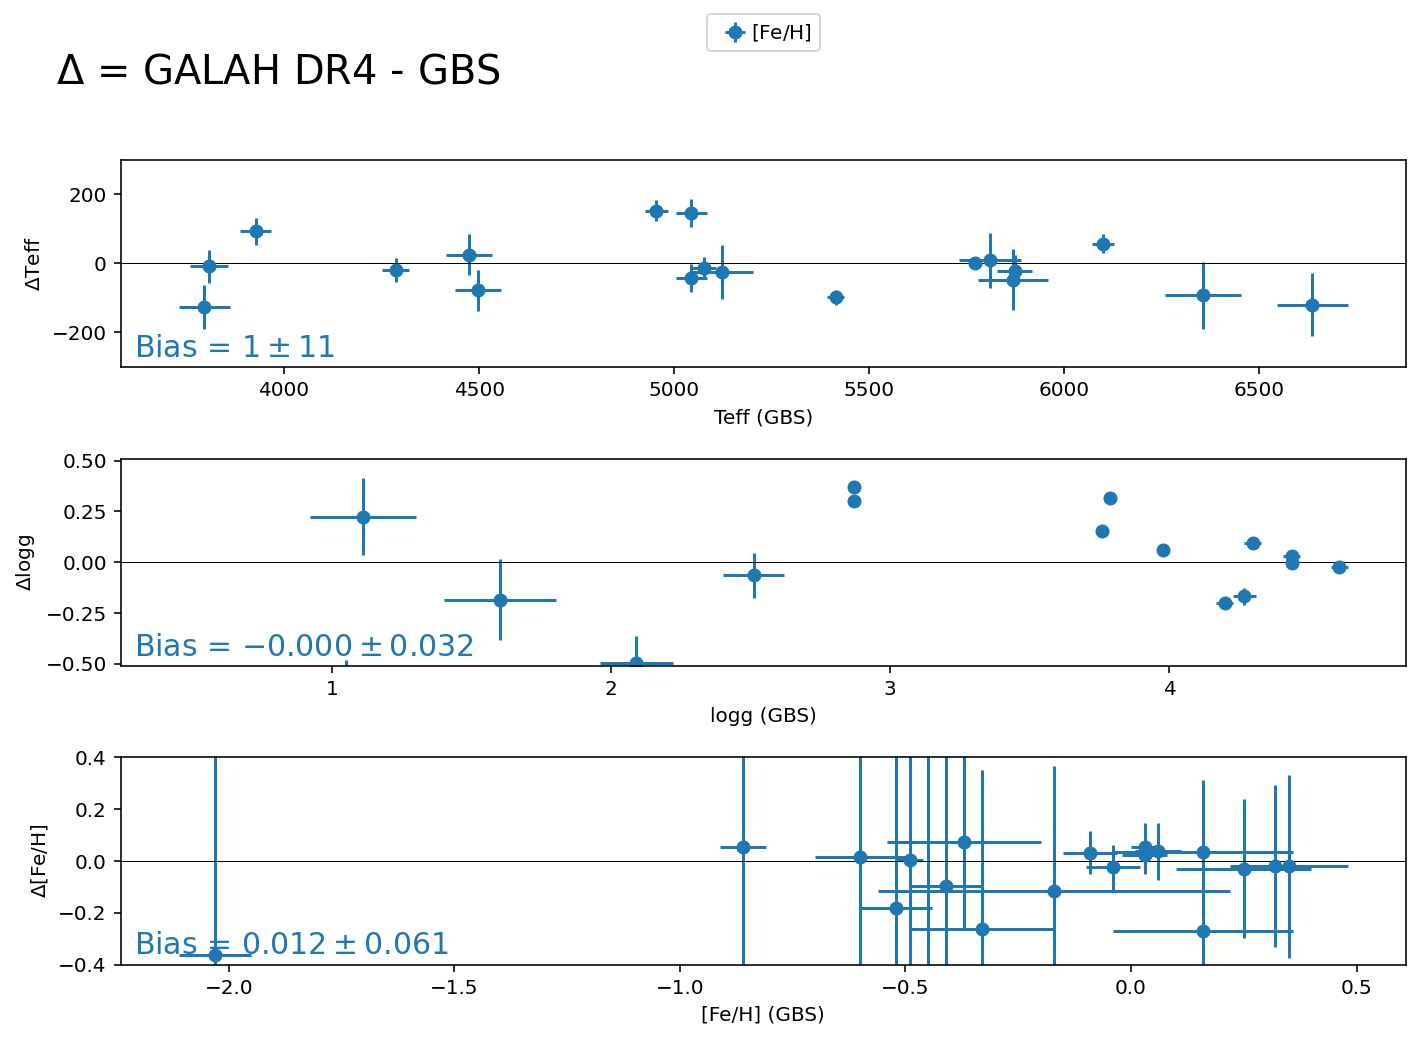

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,7.5))

s1 = ax1.errorbar(
    comparison['teff_gbs'],
    comparison['teff'] - comparison['teff_gbs'],
    xerr = comparison['e_teff_gbs'],
    yerr = np.sqrt(comparison['e_teff_gbs']**2 + comparison['e_teff']**2),
    fmt = 'o',
    label=r'$\mathrm{[Fe/H]}$'
    )

s2 = ax2.errorbar(
    comparison['logg_gbs'],
    comparison['logg'] - comparison['logg_gbs'],
    xerr = comparison['e_logg_gbs'],
    yerr = np.sqrt(comparison['e_logg_gbs']**2 + comparison['e_logg']**2),
    fmt = 'o'
    )

s3 = ax3.errorbar(
    comparison['fe_h_gbs'],
    comparison['fe_h'] - comparison['fe_h_gbs'],
    xerr = comparison['e_fe_h_gbs'],
    yerr = np.sqrt(comparison['e_fe_h_gbs']**2 + comparison['e_fe_h']**2),
    fmt = 'o'
    )

ax1.set_ylim(-300,300)
ax2.set_ylim(-0.51,0.51)
ax3.set_ylim(-0.4,0.4)

ax1.axhline(0,lw=0.5,c='k')
ax2.axhline(0,lw=0.5,c='k')
ax3.axhline(0,lw=0.5,c='k')

ax1.set_xlabel('Teff (GBS)')
ax2.set_xlabel('logg (GBS)')
ax3.set_xlabel('[Fe/H] (GBS)')

ax1.set_ylabel(r'$\Delta$Teff')
ax2.set_ylabel(r'$\Delta$logg')
ax3.set_ylabel(r'$\Delta$[Fe/H]')

ax1.text(0.01,0.05,r'Bias = $'+str('%.0f' % lbol_bias['teff'][0])+' \pm '+str('%.0f' % lbol_bias['teff'][1])+'$',transform=ax1.transAxes,color='C0',fontsize=15)
ax2.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['logg'][0])+' \pm '+str('%.3f' % lbol_bias['logg'][1])+'$',transform=ax2.transAxes,color='C0',fontsize=15)
ax3.text(0.01,0.05,r'Bias = $'+str('%.3f' % lbol_bias['fe_h'][0])+' \pm '+str('%.3f' % lbol_bias['fe_h'][1])+'$',transform=ax3.transAxes,color='C0',fontsize=15)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75),ncol=4, fancybox=True,handletextpad=-0.2,columnspacing=0.25)
ax1.text(-0.05,1.37,r'$\Delta$ = GALAH DR4 - GBS',transform=ax1.transAxes,fontsize=20)

plt.tight_layout()
plt.savefig('figures/gbs_performance_lbol.png',bbox_inches='tight',dpi=300)